In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./kaggle/input'):
#for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./kaggle/input/Kannada-MNIST/train.csv
./kaggle/input/Kannada-MNIST/sample_submission.csv
./kaggle/input/Kannada-MNIST/test.csv
./kaggle/input/Kannada-MNIST/Dig-MNIST.csv


# Imports - loading the data

I used this notebook:
https://www.kaggle.com/code/gabmars/pytorch-lenet5

In [2]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import torchmetrics
from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device) # Might as well find out! 

/home/szekeres/anaconda3/envs/pytorch-gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


In [3]:
train_data = pd.read_csv('./kaggle/input/Kannada-MNIST/train.csv')

In [4]:
test_data = pd.read_csv('./kaggle/input/Kannada-MNIST/Dig-MNIST.csv')

In [5]:
train_data.shape

(60000, 785)

In [6]:
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
test_data.shape

(10240, 785)

In [8]:
train_data = train_data.sample(frac=1,random_state=32).reset_index(drop=True)

In [9]:
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# split the data into features and target label
X, y = (train_data.drop(['label'], axis=1), train_data.label)
X_t, y_t = (test_data.drop(['label'], axis=1), test_data.label)

In [11]:
class KannadaDataSet(torch.utils.data.Dataset):
    def __init__(self, images, labels, transforms = None):
        self.images = images
        self.labels = labels
        self.transforms = transforms
         
    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self, i):
        data = np.array(self.images.iloc[i,:]).astype(np.uint8).reshape(28,28,1)
        
        if self.transforms:
            data = self.transforms(data)
            
        return (data, self.labels[i])

In [12]:
transform = transforms.Compose(([
    transforms.ToTensor(),
]))

In [13]:
X.shape, y.shape, type(X)

((60000, 784), (60000,), pandas.core.frame.DataFrame)

In [14]:
X[1000:2000]

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
1000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
learn_num = int(len(X)*0.75)

In [16]:
train_set = KannadaDataSet(X[:learn_num].reset_index(drop=True), y[:learn_num].reset_index(drop=True), transform)
valid_set = KannadaDataSet(X[learn_num:].reset_index(drop=True), y[learn_num:].reset_index(drop=True), transform)
test_set = KannadaDataSet(X_t, y_t, transform)

In [17]:
torch.manual_seed(43)
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=100, 
                                           shuffle=False)

valid_loader = torch.utils.data.DataLoader(valid_set,
                                          batch_size=100, 
                                          shuffle=False)

test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=100, 
                                          shuffle=False)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

tensor([3, 1, 1, 3, 3, 7, 5, 4, 9, 8, 8, 8, 8, 9, 3, 9, 7, 3, 3, 5, 3, 1, 6, 8,
        9, 9, 4, 9, 0, 0, 4, 8, 4, 2, 8, 8, 8, 5, 8, 9, 4, 7, 8, 5, 9, 8, 2, 0,
        6, 0, 5, 4, 1, 4, 3, 4, 7, 8, 5, 7, 6, 3, 0, 8, 2, 3, 2, 1, 7, 0, 1, 5,
        9, 4, 7, 3, 8, 6, 6, 4, 3, 7, 9, 2, 4, 1, 7, 0, 9, 3, 4, 4, 8, 1, 3, 0,
        4, 5, 0, 1])


tensor(1.)

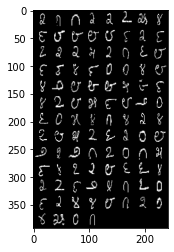

In [18]:
images, labels = next(iter(train_loader))
plt.imshow(torchvision.utils.make_grid(images)[0,:,:], cmap='gray')
print(labels)
images[0,:,:].max()

# Helper functions

In [19]:
import time
def train(train_loader,valid_loader,test_loader,model,optimizer,criterion,num_epochs=10,lr_scheduler=None):
    """
    Function for training
    
    train_loader : training dataset loader
    valid_loader : validation dataset loader
    optimizer : optimizer algorithm
    criterion : loss function
    num_epochs : number of epochs
    
    The function returns (train_loss_list, train_acc_list, valid_loss_list, valid_acc_list), where
    train_loss_list : average loss on mini-batches in the training set
    train_acc_list : training accuracy
    valid_loss_list : average loss on mini-batches in the validation set
    valid_acc_list : average validation accuracy
    """
    
    train_loss_list = []
    valid_loss_list = []
    test_loss_list = []
    train_acc_list = []
    valid_acc_list = []
    test_acc_list = []

    epoch = 0
    start = time.time()
    
    while epoch < num_epochs:
        epoch+=1
            
        train_loss_temp = []
        train_acc_temp = 0.0
        train_total_samples = 0
    
        # training phase
        for i, data in enumerate(train_loader, 0):

            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # training loss
            train_loss_temp.append(loss.item())
        
            # training accuracy
            _, predicted = torch.max(outputs.data, 1)
            train_acc_temp += (predicted == labels).sum().item()
            train_total_samples += labels.size(0)
        
        train_loss_list.append(np.mean(train_loss_temp))
        train_acc_list.append(train_acc_temp/train_total_samples)
    
        # validation set
        with torch.no_grad():
            valid_loss_temp = []
            valid_acc_temp = 0.0
            valid_total_samples = 0
            model.eval()
        
            for v_i, v_data in enumerate(valid_loader,0):
                v_inputs, v_labels = v_data[0].to(device), v_data[1].to(device)
                v_outputs = model(v_inputs)
                v_loss = criterion(v_outputs,v_labels)
            
                valid_loss_temp.append(v_loss.item())
                _, predicted = torch.max(v_outputs.data,1)
                
            
                valid_total_samples += v_labels.size(0)
                valid_acc_temp += (predicted == v_labels).sum().item()
            
            valid_loss_list.append(np.mean(valid_loss_temp))
            valid_acc_list.append(valid_acc_temp/valid_total_samples)
            
        # test set
        with torch.no_grad():
            test_loss_temp = []
            test_acc_temp = 0.0
            test_total_samples = 0
            model.eval()
        
            for t_i, t_data in enumerate(test_loader,0):
                t_inputs, t_labels = t_data[0].to(device), t_data[1].to(device)
                t_outputs = model(t_inputs)
                t_loss = criterion(t_outputs,t_labels)
            
                test_loss_temp.append(t_loss.item())
                _, predicted = torch.max(t_outputs.data,1)
                
            
                test_total_samples += t_labels.size(0)
                test_acc_temp += (predicted == t_labels).sum().item()
            
            test_loss_list.append(np.mean(test_loss_temp))
            test_acc_list.append(test_acc_temp/test_total_samples)

        model.train()   
        
        # Scheduler
        if lr_scheduler:
            lr_scheduler.step()
            
        end = time.time()
    
        # Displaying the results
        print(f"[{epoch}/{num_epochs}] | LE: {train_loss_list[-1]:.6f} LA: {train_acc_list[-1]:.6f} | VE {valid_loss_list[-1]:.6f} VA: {valid_acc_list[-1]:.6f} | TE {test_loss_list[-1]:.6f} TA: {test_acc_list[-1]:.6f} | ET: {end-start:.2f}s")

    result_dict = {"training loss": train_loss_list, 
                   "training acc": train_acc_list,
                   "validation loss": valid_loss_list, 
                   "validation acc": valid_acc_list,
                   "test loss": test_loss_list, 
                   "test acc": test_acc_list}
        
    return result_dict

In [20]:
def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "epoch: {}, test acc: {:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->")#,connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)

def plot_acc_loss(result_dict):
    """
    Plotting function
    
    result_dict : containing the results from the `train` function
    """
    
    train_acc_list = result_dict["training acc"]
    train_loss_list = result_dict["training loss"]
    valid_acc_list = result_dict["validation acc"]
    valid_loss_list = result_dict["validation loss"]
    test_acc_list = result_dict["test acc"]
    test_loss_list = result_dict["test loss"]
    
    fig, ax = plt.subplots(1, 2, figsize = (8, 4))
    
    x = np.arange(1,len(train_acc_list)+1)
    
    ax[0].set_title('Accuracies')
    ax[0].plot(x,valid_acc_list, color = 'blue', label = 'validation')
    ax[0].plot(x,test_acc_list, color = 'red', label = 'test')
    
    annot_max(x,np.array(test_acc_list),ax[0])
    ax[0].legend()

    ax[1].set_title('Losses')
    ax[1].plot(x,valid_loss_list, color = 'blue', label = 'validation')
    ax[1].plot(x,test_loss_list, color = 'red', label = 'test')
    ax[1].legend()

    plt.show() 

# Model

I used https://www.kaggle.com/code/gabmars/pytorch-lenet5 here again.

In [21]:
class Net(nn.Module):
    def __init__(self, dropout = 0.40):
        super(Net, self).__init__()
        self.dropout = dropout
        
        # https://blog.algorithmia.com/convolutional-neural-nets-in-pytorch
        #Our batch shape for input x is (1, 28, 28)
        # (Batch, Number Channels, height, width).
        #Input channels = 1, output channels = 18
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.conv1_bn = nn.BatchNorm2d(num_features=64)
        
        self.conv1_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.conv1_1_bn = nn.BatchNorm2d(num_features=64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.d2_1 = nn.Dropout2d(p=self.dropout)
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv2_bn = nn.BatchNorm2d(num_features=128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.d2_2 = nn.Dropout2d(p=self.dropout)
        
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv3_bn = nn.BatchNorm2d(num_features=256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.d2_3 = nn.Dropout2d(p=self.dropout)
        
        #4608 input features, 256 output features (see sizing flow below)
        self.fc1 = nn.Linear(256 * 3 * 3, 512) # Linear 1
        self.d1_1 = nn.Dropout(p=self.dropout)
        #64 input features, 10 output features for our 10 defined classes
        self.fc2 = nn.Linear(in_features=512, out_features=256) # linear 2
        self.d1_2 = nn.Dropout(p=self.dropout)
        self.fc3 = nn.Linear(in_features=256, out_features=128) # linear 3
        self.d1_3 = nn.Dropout(p=self.dropout)
        self.out = nn.Linear(in_features=128, out_features=10) # linear 3
        
    def forward(self, x):
        #Computes the activation of the first convolution
        #Size changes from (1, 28, 28) to (18, 28, 28)
        x = self.conv1(x)
        x = self.conv1_bn(x)
        x = F.relu(x)
        x = self.conv1_1(x)
        x = self.conv1_1_bn(x)
        x = F.relu(x)       
        
        x = self.d2_1(x)
        x = self.pool1(x) # Size changes from (18, 28, 28) to (18, 14, 14)
        
        # Second Conv       
        x = self.conv2(x)
        x = self.conv2_bn(x)
        x = F.relu(x)
        x = self.d2_2(x)
        x = self.pool2(x) # Size changes from (18, 14, 14) to (18, 7, 7)
        
        # Third Conv       
        x = self.conv3(x)
        x = self.conv3_bn(x)
        x = F.relu(x)
        x = self.d2_3(x)
        x = self.pool3(x) # Size changes from (18, 7, 7) to (18, 3, 3)
        
        #Reshape data to input to the input layer of the neural net
        #Size changes from (18, 14, 14) to (1, 3528)
        #Recall that the -1 infers this dimension from the other given dimension
        x = x.view(-1, 256 * 3 * 3)

        #Computes the activation of the first fully connected layer
        #Size changes from (1, 4608) to (1, 64)
        #Computes the second fully connected layer (activation applied later)
        #Size changes from (1, 64) to (1, 10)
        x = F.relu(self.fc1(x))
        x = self.d1_1(x)
        
        x = F.relu(self.fc2(x))
        x = self.d1_2(x)
        
        x = F.relu(self.fc3(x))
        x = self.d1_3(x)
        
        x = self.out(x)
        return F.log_softmax(x, dim=-1)

In [22]:
import math

In [23]:
# Learning Rate Finder https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html
# https://www.kaggle.com/code/nicapotato/pytorch-cnn-kanada/notebook
def find_lr(trn_loader, init_value = 1e-8, final_value=10., beta = 0.98):
    num = len(trn_loader)-1
    mult = (final_value / init_value) ** (1/num)
    lr = init_value
    optimizer.param_groups[0]['lr'] = lr
    avg_loss = 0.
    best_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    for data in trn_loader:
        batch_num += 1
        #As before, get the loss for this mini-batch of inputs/outputs
        inputs = data[0].to(device)
        labels = data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        #Compute the smoothed loss
        avg_loss = beta * avg_loss + (1-beta)*loss.item()
        smoothed_loss = avg_loss / (1 - beta**batch_num)
        #Stop if the loss is exploding
        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            return log_lrs, losses
        #Record the best loss
        if smoothed_loss < best_loss or batch_num==1:
            best_loss = smoothed_loss
        #Store the values
        losses.append(smoothed_loss)
        log_lrs.append(math.log10(lr))
        #Do the SGD step
        loss.backward()
        optimizer.step()
        #Update the lr for the next step
        lr *= mult
        optimizer.param_groups[0]['lr'] = lr
    return log_lrs, losses

In [24]:
torch.manual_seed(42)
net = Net().to(device)

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

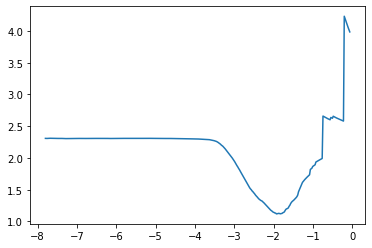

In [26]:
logs,losses = find_lr(trn_loader = train_loader)
plt.plot(logs[10:-5],losses[10:-5])

In [27]:
summary(net, input_size = (1, 28, 28), device = 'cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]           1,664
       BatchNorm2d-2           [-1, 64, 28, 28]             128
            Conv2d-3           [-1, 64, 28, 28]         102,464
       BatchNorm2d-4           [-1, 64, 28, 28]             128
         Dropout2d-5           [-1, 64, 28, 28]               0
         MaxPool2d-6           [-1, 64, 14, 14]               0
            Conv2d-7          [-1, 128, 14, 14]          73,856
       BatchNorm2d-8          [-1, 128, 14, 14]             256
         Dropout2d-9          [-1, 128, 14, 14]               0
        MaxPool2d-10            [-1, 128, 7, 7]               0
           Conv2d-11            [-1, 256, 7, 7]         295,168
      BatchNorm2d-12            [-1, 256, 7, 7]             512
        Dropout2d-13            [-1, 256, 7, 7]               0
        MaxPool2d-14            [-1, 25

In [28]:
# https://discuss.pytorch.org/t/how-to-do-exponential-learning-rate-decay-in-pytorch/63146
torch.manual_seed(42)
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=5e-3)
decayRate = 0.96
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

In [ ]:
result_dict = train(train_loader,valid_loader,test_loader,net,optimizer,criterion,10,lr_scheduler)

[1/10] | LE: 0.535823 LA: 0.820956 | VE 0.078959 VA: 0.982933 | TE 1.630880 TA: 0.736523 | ET: 35.54s
[2/10] | LE: 0.161252 LA: 0.961511 | VE 0.053548 VA: 0.987933 | TE 1.474739 TA: 0.752930 | ET: 71.56s
[3/10] | LE: 0.116056 LA: 0.973267 | VE 0.044100 VA: 0.988267 | TE 1.292880 TA: 0.757617 | ET: 107.04s
[4/10] | LE: 0.102362 LA: 0.976022 | VE 0.047735 VA: 0.988667 | TE 1.856517 TA: 0.740527 | ET: 142.64s
[5/10] | LE: 0.098767 LA: 0.977844 | VE 0.033155 VA: 0.991400 | TE 1.327521 TA: 0.786719 | ET: 178.47s
[6/10] | LE: 0.078699 LA: 0.981733 | VE 0.030670 VA: 0.991667 | TE 1.705764 TA: 0.766211 | ET: 213.66s
[7/10] | LE: 0.070362 LA: 0.983644 | VE 0.026607 VA: 0.992667 | TE 1.380007 TA: 0.805273 | ET: 249.37s
[8/10] | LE: 0.070711 LA: 0.984067 | VE 0.033851 VA: 0.992067 | TE 1.337581 TA: 0.812988 | ET: 284.64s
[9/10] | LE: 0.069932 LA: 0.984667 | VE 0.030941 VA: 0.992600 | TE 1.292814 TA: 0.819531 | ET: 320.20s


In [ ]:
plot_acc_loss(result_dict)

# Submission

In [ ]:
test_data = pd.read_csv('./kaggle/input/Kannada-MNIST/test.csv')
#test_data = pd.read_csv('/kaggle/input/Kannada-MNIST/test.csv')

In [ ]:
ids, test_set = test_data.id, test_data.drop(['id'], axis=1)

In [ ]:
test_set = torch.from_numpy(test_set.values)
test_set = test_set.view(test_set.shape[0],28,28).to(device)

In [ ]:
test_set.shape

In [ ]:
test_set.max()

In [ ]:
test_set = test_set/255.

In [ ]:
predictions=[]
with torch.no_grad():
    for i, data in enumerate(test_set):
        images = data.to(device)
        outputs = net(images.float().unsqueeze(0).unsqueeze(0))
        
        _, predicted = torch.max(outputs.data, 1)
        #print(f"{outputs.data} \n ---> {predicted} \n----------------")
        predictions.append([i,predicted.item()])

In [ ]:
predicted

In [ ]:
predictions=pd.DataFrame(predictions)

In [ ]:
predictions.columns=['id','label']

In [ ]:
predictions.to_csv('./kaggle/working/submission.csv', index=False)

In [ ]:
torch.__version__